# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import Featlin
# from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
# from src.featlin import linearization_plots
# from src.featlin import linearization_regeression_row_plots

from src.helper import optimise_pls_cv
from src.helper import optimize_regcoef_nrmse
from src.helper import optimize_regcoef_dist
from src.helper import plot_x_tt2

import src.basis as basis
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

In [5]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [6]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

# X = X_lfp_train-np.mean(X_lfp, axis=0)
# y_gt = np.zeros([X.shape[0], 5, 1])
# for j in range(len(fun_targetj)): 
#     y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [7]:
# Generate BasicsData class objects
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Mean
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sum Squares
lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Variance
lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_var = lfp_var.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Skew
lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Kurt
lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

['PLS 4 comp', 'lfun']
Alpha NRMSE: 7.62842305708736e-05
Beta NRMSE: 7.274834661701795e-05
Max NRMSE: 0.15
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.00031914557602974735
Beta NRMSE: 0.0004411911385974728
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma: 12.022644346174118
Gamma: 13.67728825595848
Gamma: 15.559656316050734
Gamma: 17.701089583174202
Gamma value corresponding to nrmse=0.1577 % is 17.701
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.00031914557602974735
Beta NRMSE: 0.001464734783152591
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 3981.071705534969
Gamma: 158.48931924611108
Gamma: 301.9951720402013
Gamma: 575.439937337156
Gamma: 301.9951720402013
Gamma: 343.5579478998743
Gamma: 390.8408957924017
Gamma value corresponding to nrmse=0.1555 % is 390.841
['P

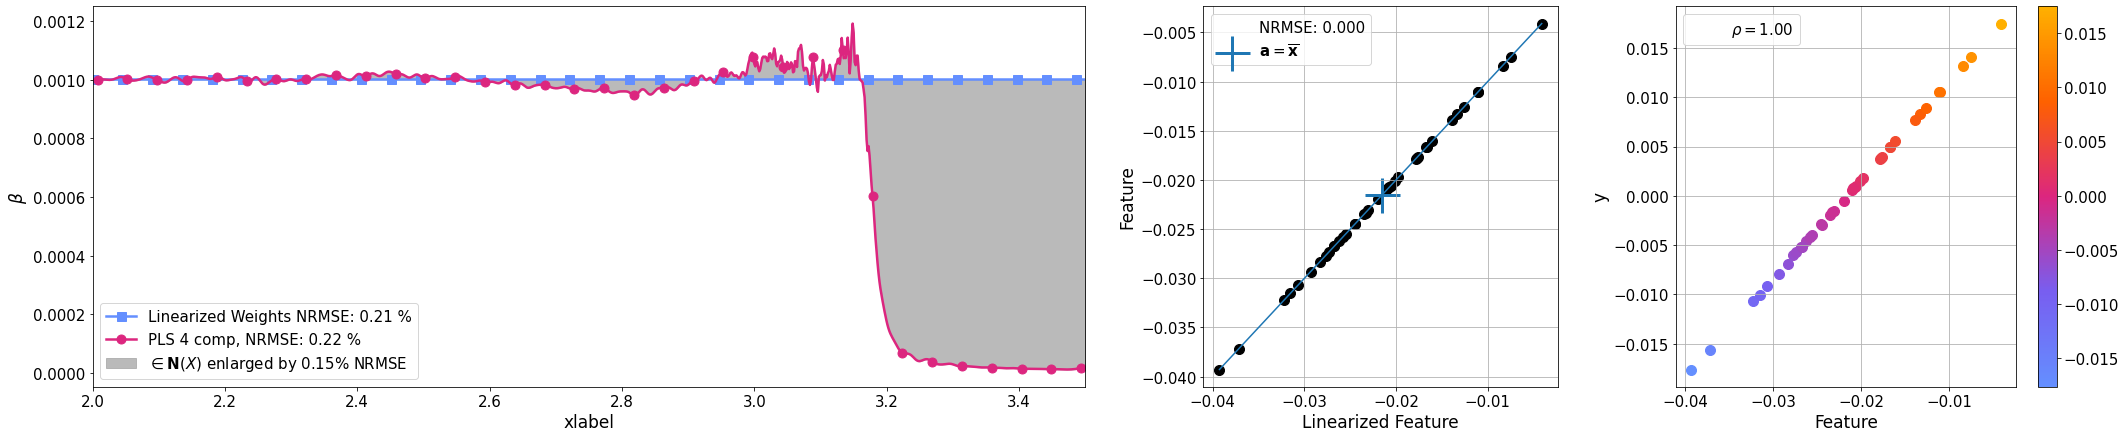

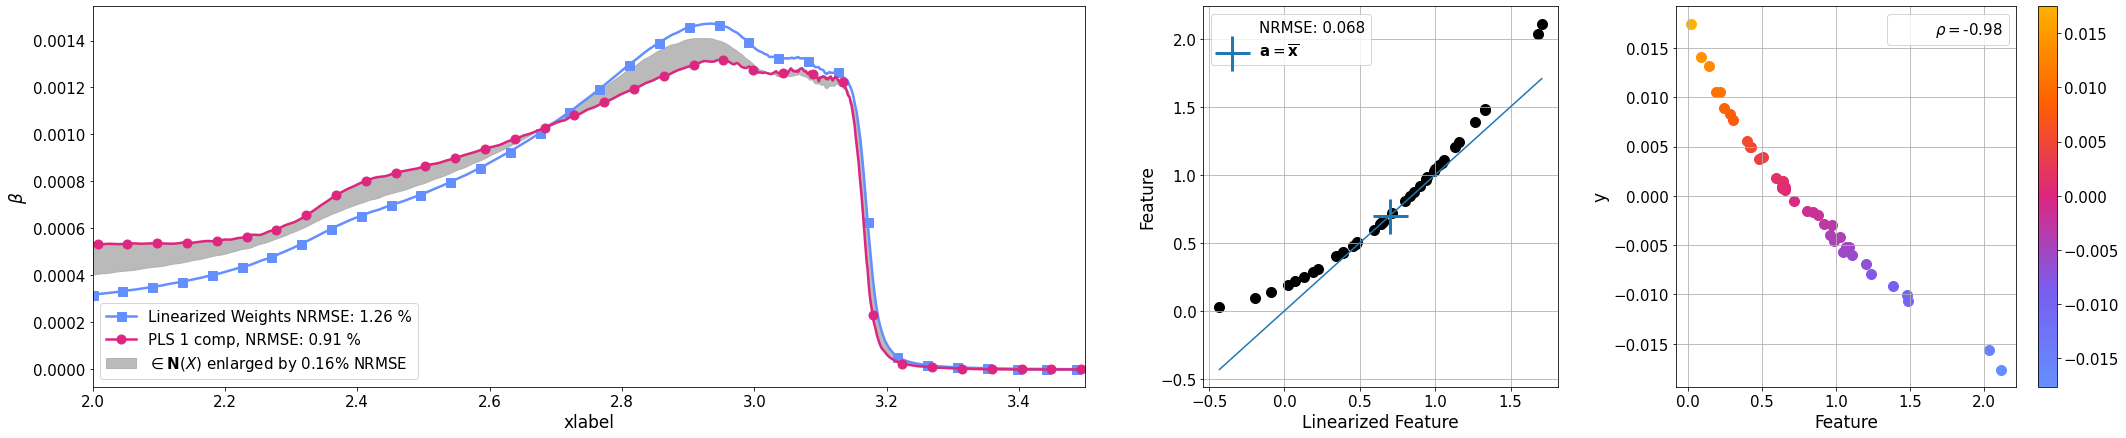

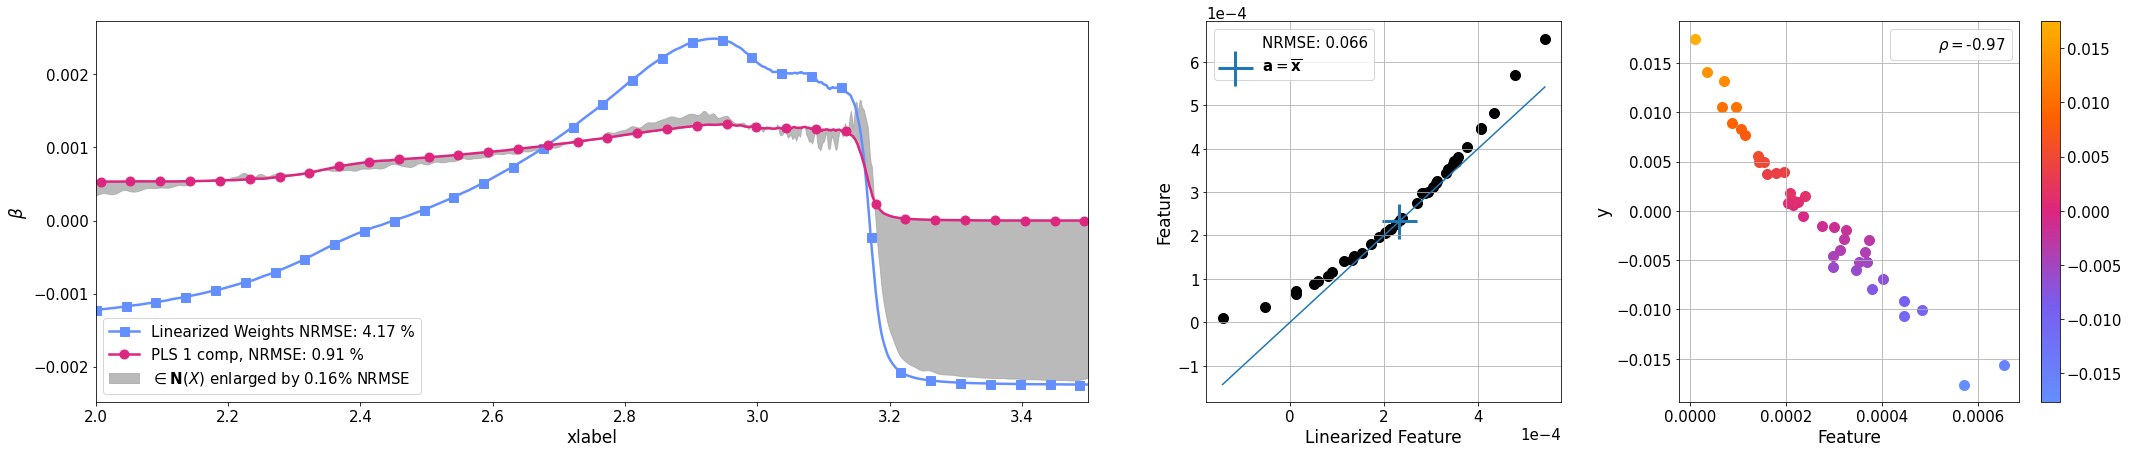

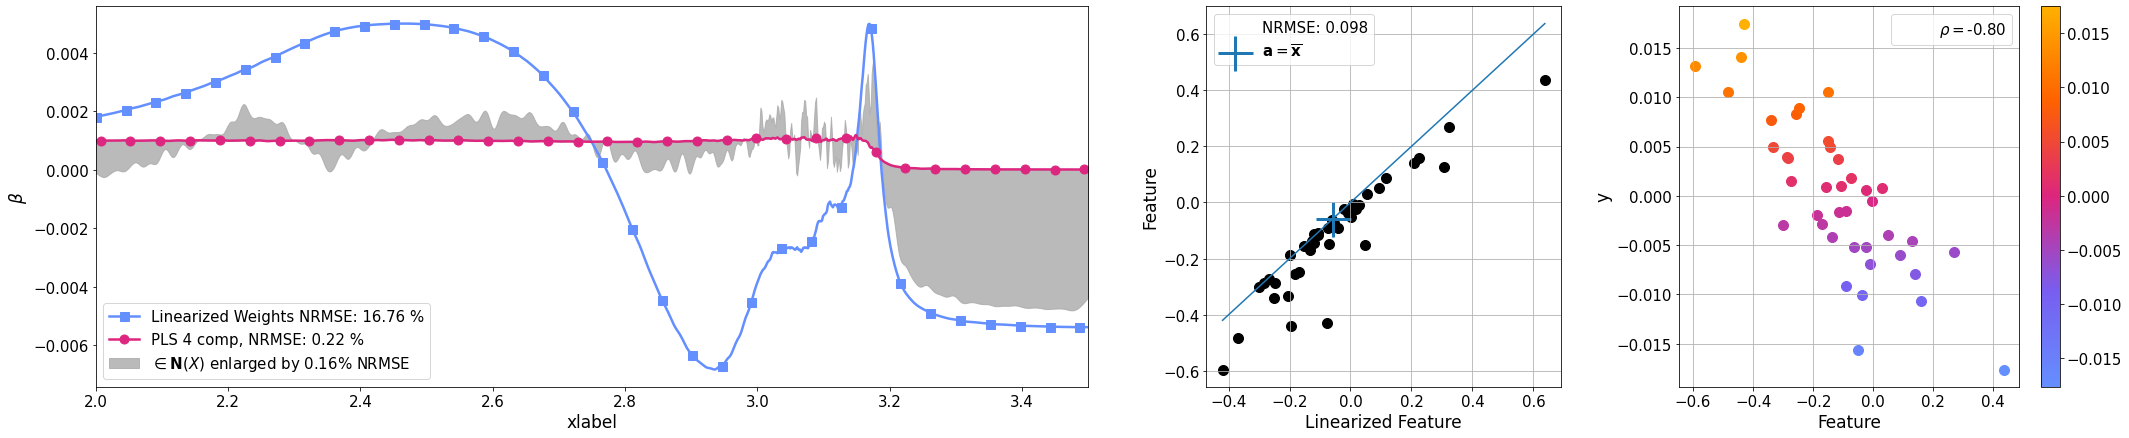

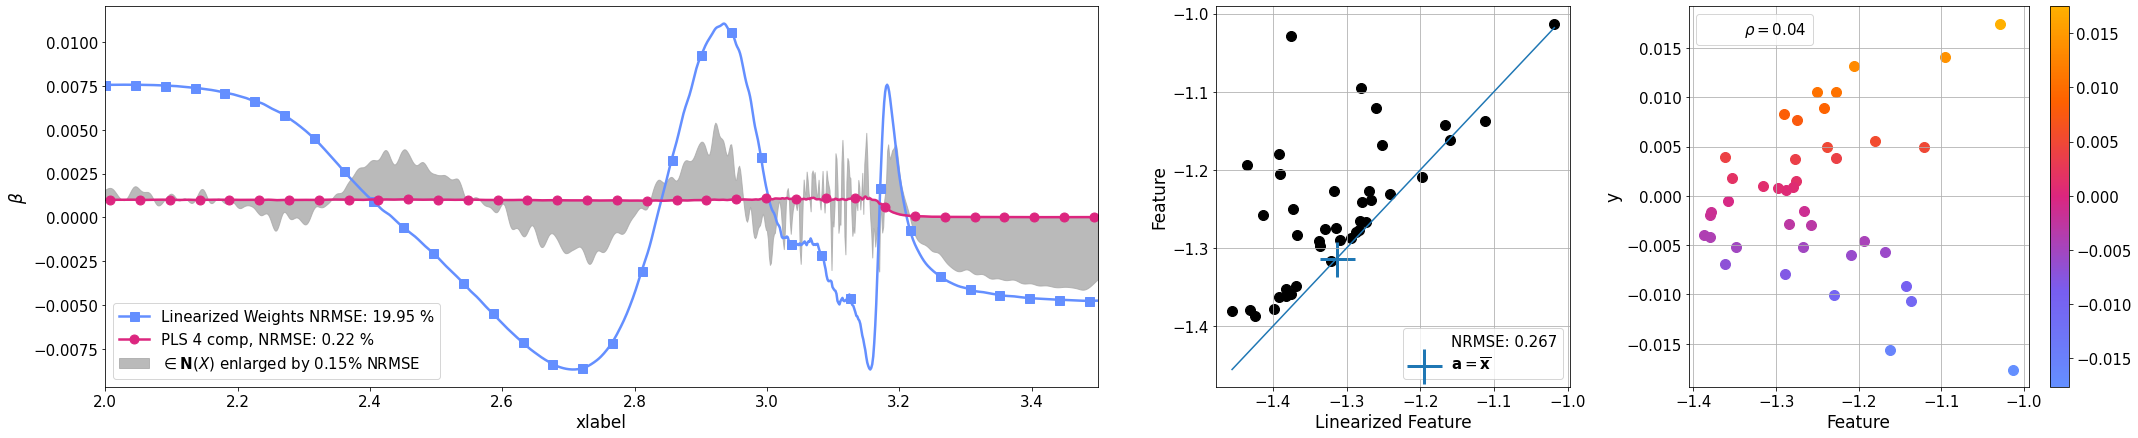

In [8]:
# Inititate the class with data (x, y) & features that you want to test
lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)
lfp_meangt = lfp_meangt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)

['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.10745882080211365
Beta NRMSE: 0.10246646576093284
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma: 12.022644346174118
Gamma: 13.67728825595848
Gamma: 15.559656316050734
Gamma: 17.701089583174202
Gamma value corresponding to nrmse=0.1483 % is 17.701
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.10745882080211365
Beta NRMSE: 0.11149190048073251
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma value corresponding to nrmse=0.1532 % is 6.310
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.10745882080211365
Beta NRMSE: 0.14947101246676037
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 3981.071705534969
Gamma: 158.48931924611108
Gamma: 301.9951720402013
Gamma: 158.48931924611108
Gamma: 180.

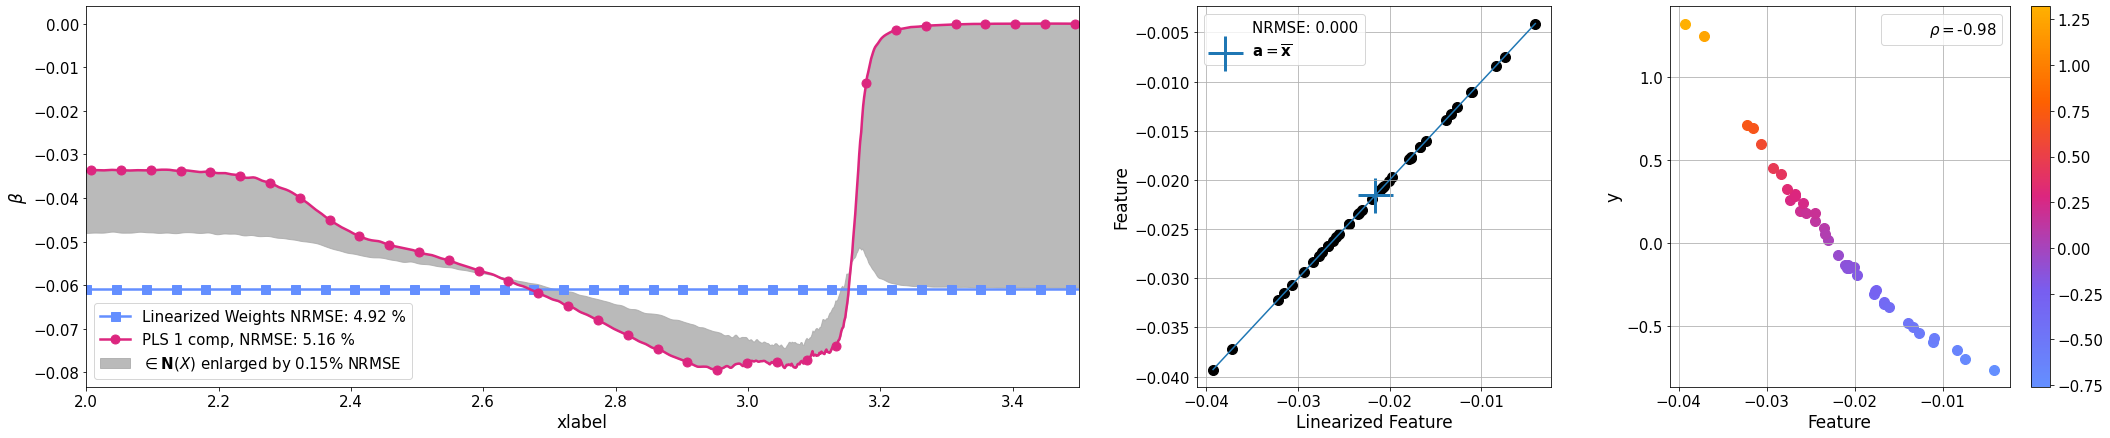

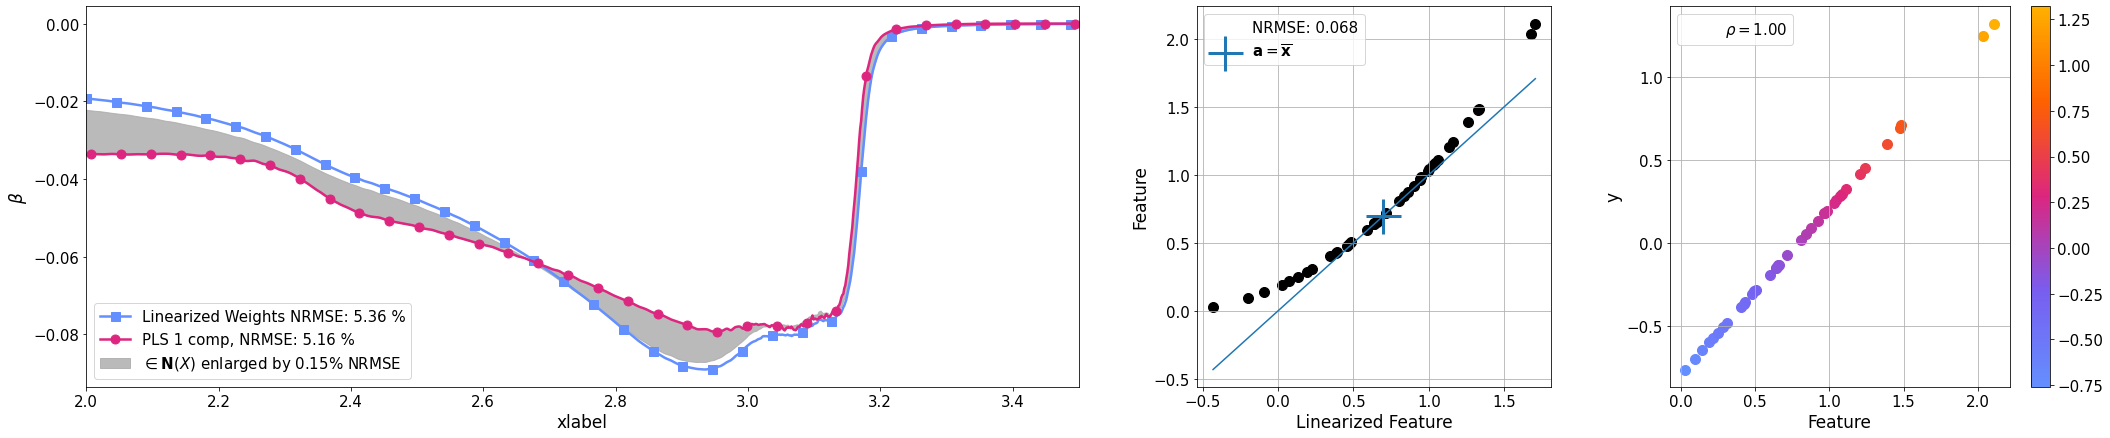

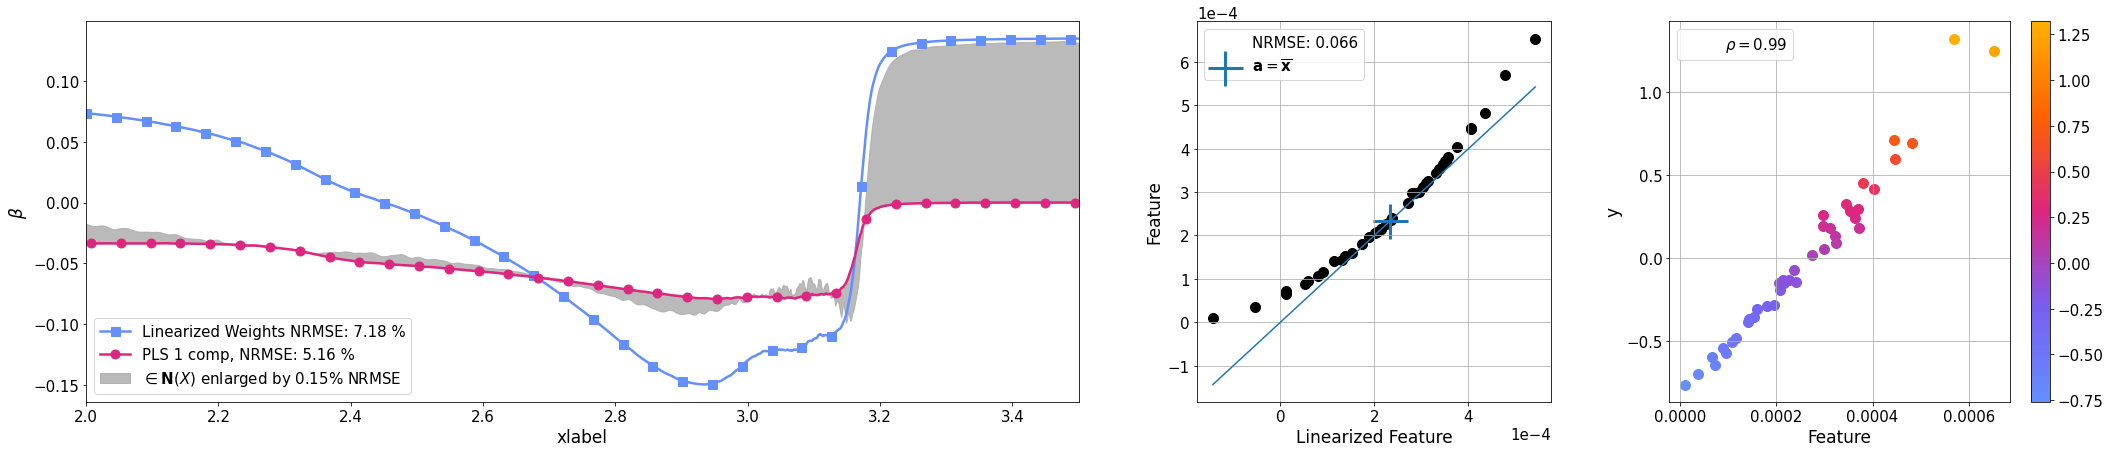

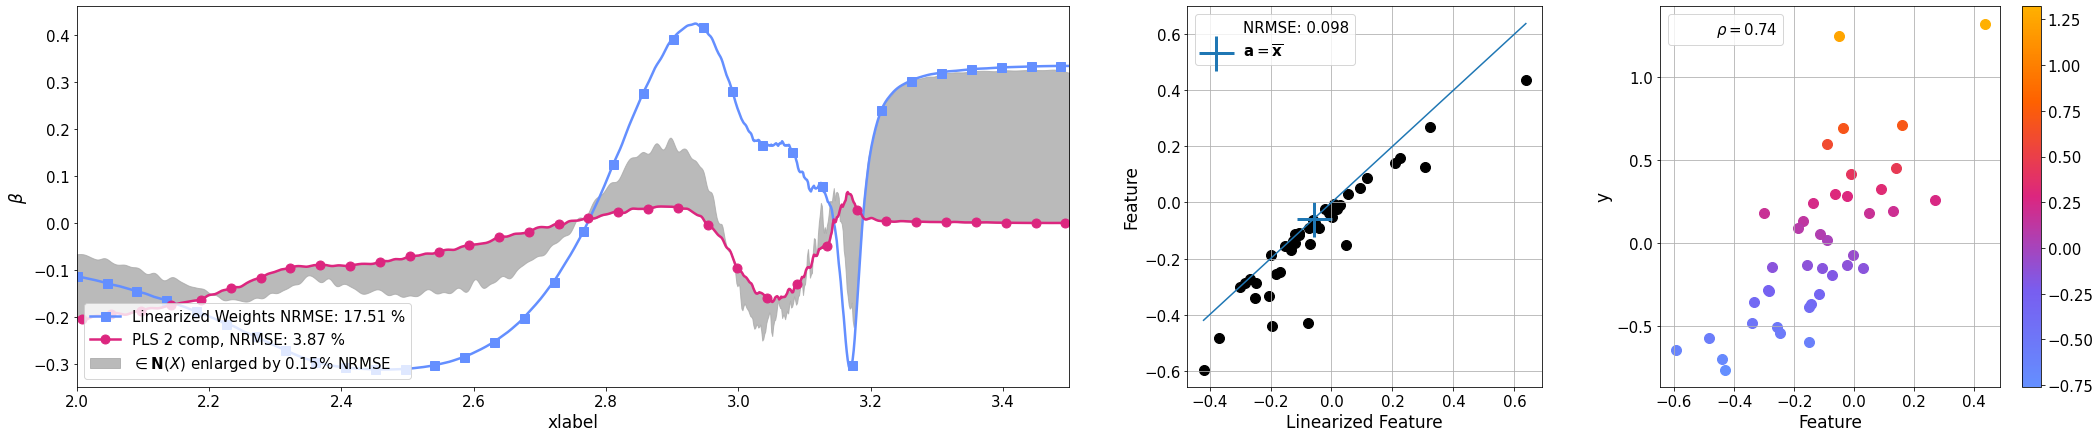

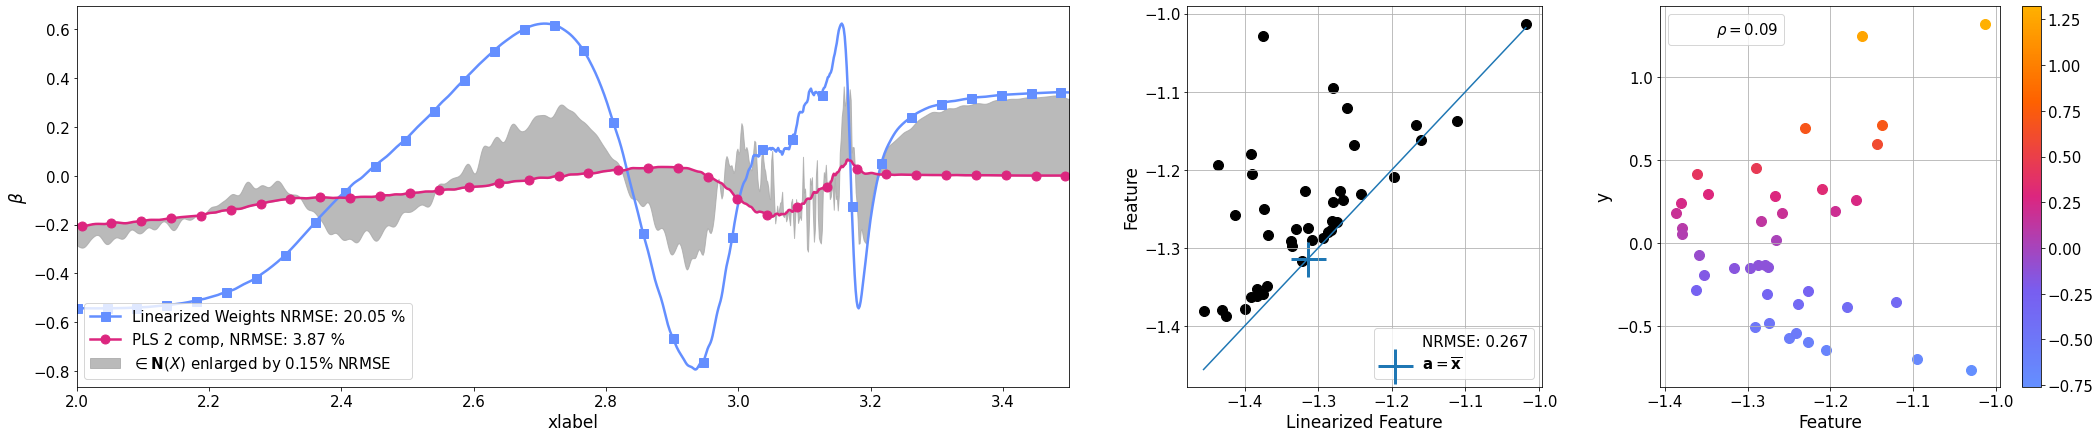

In [9]:
# Inititate the class with data (x, y) & features that you want to test
lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

# Run the tests
lfp_sums_gt = lfp_sums_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
Alpha NRMSE: 3.133384632461053e-05
Beta NRMSE: 3.409814654363726e-05
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma: 12.022644346174118
Gamma: 13.67728825595848
Gamma: 15.559656316050734
Gamma: 17.701089583174202
Gamma: 20.137242498623863
Gamma: 22.908676527677713
Gamma: 20.137242498623863
Gamma: 20.663315175644808
Gamma value corresponding to nrmse=0.1528 % is 20.663
['PLS 1 comp', 'lfun']
Alpha NRMSE: 3.133384632461053e-05
Beta NRMSE: 3.1160502409493186e-05
Max NRMSE: 0.15
['PLS 2 comp', 'lfun']
Alpha NRMSE: 2.6300825712048004e-05
Beta NRMSE: 3.220920373907956e-05
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma: 43.65158322401656
Gamma: 83.176377110267
Gam

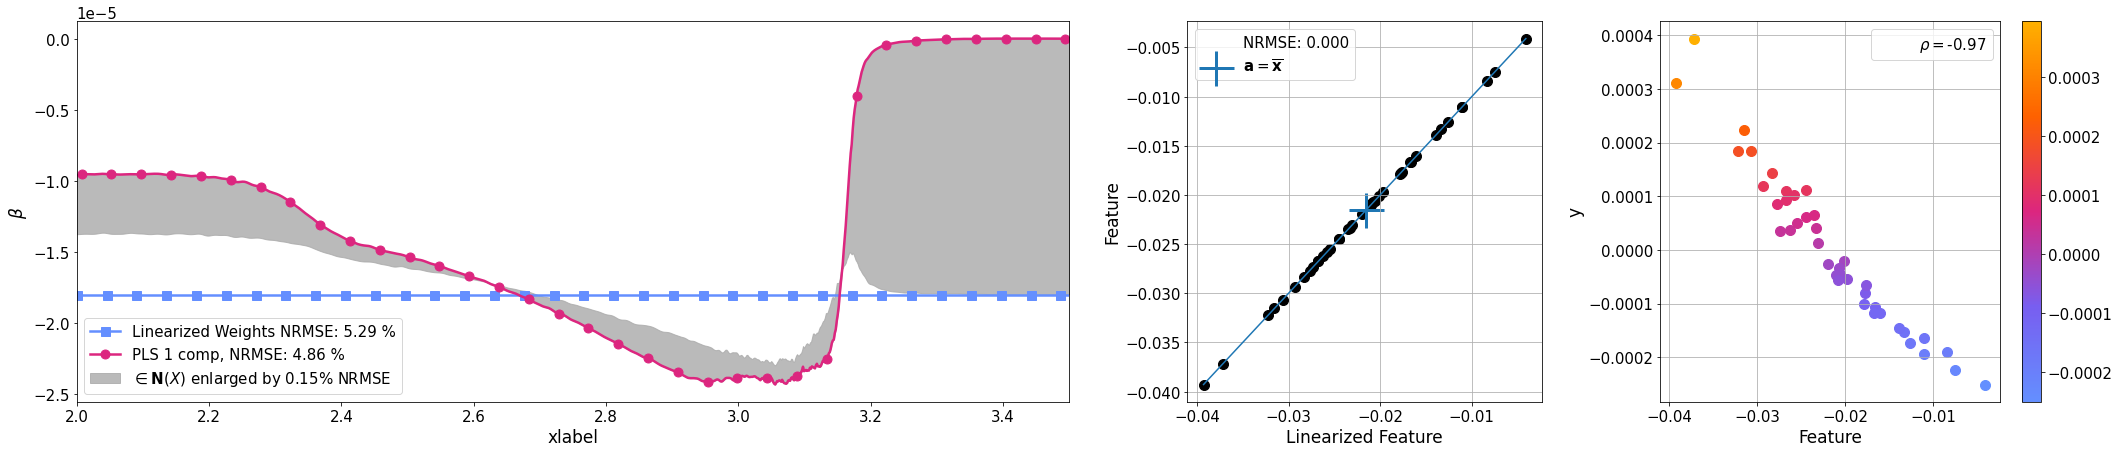

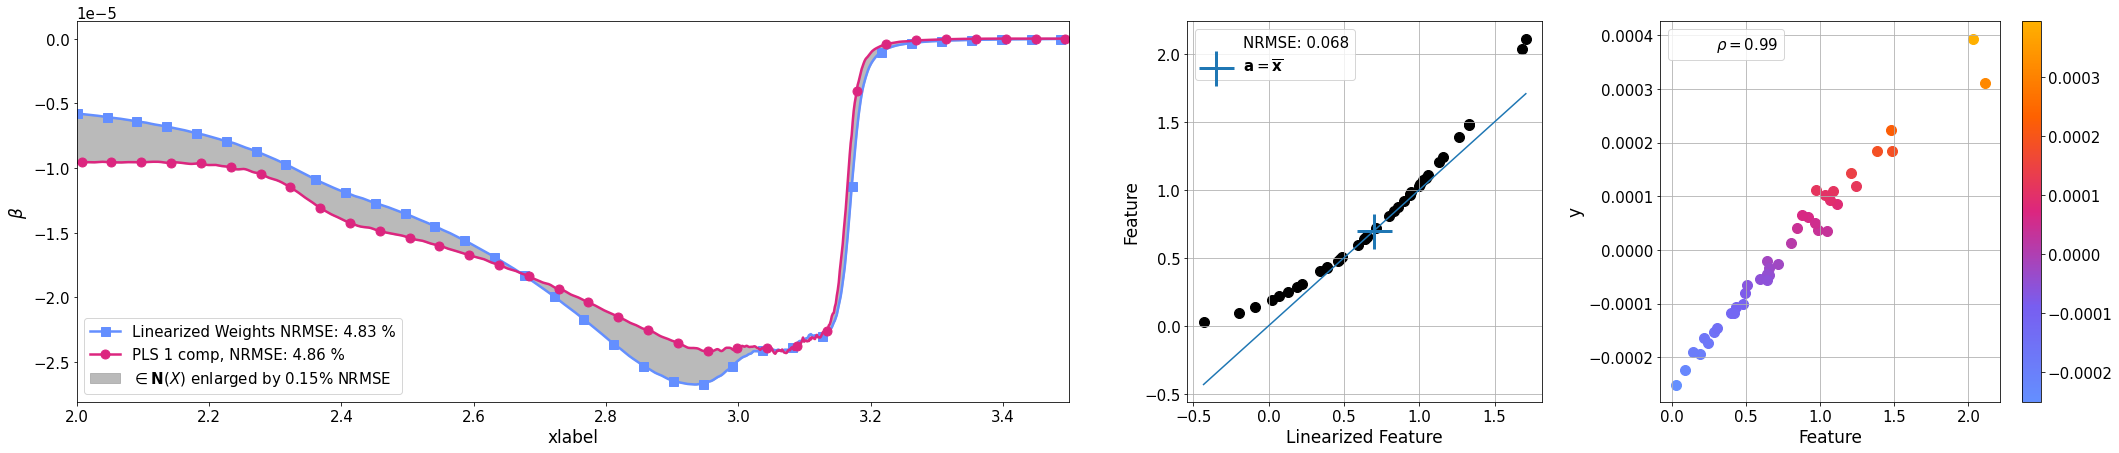

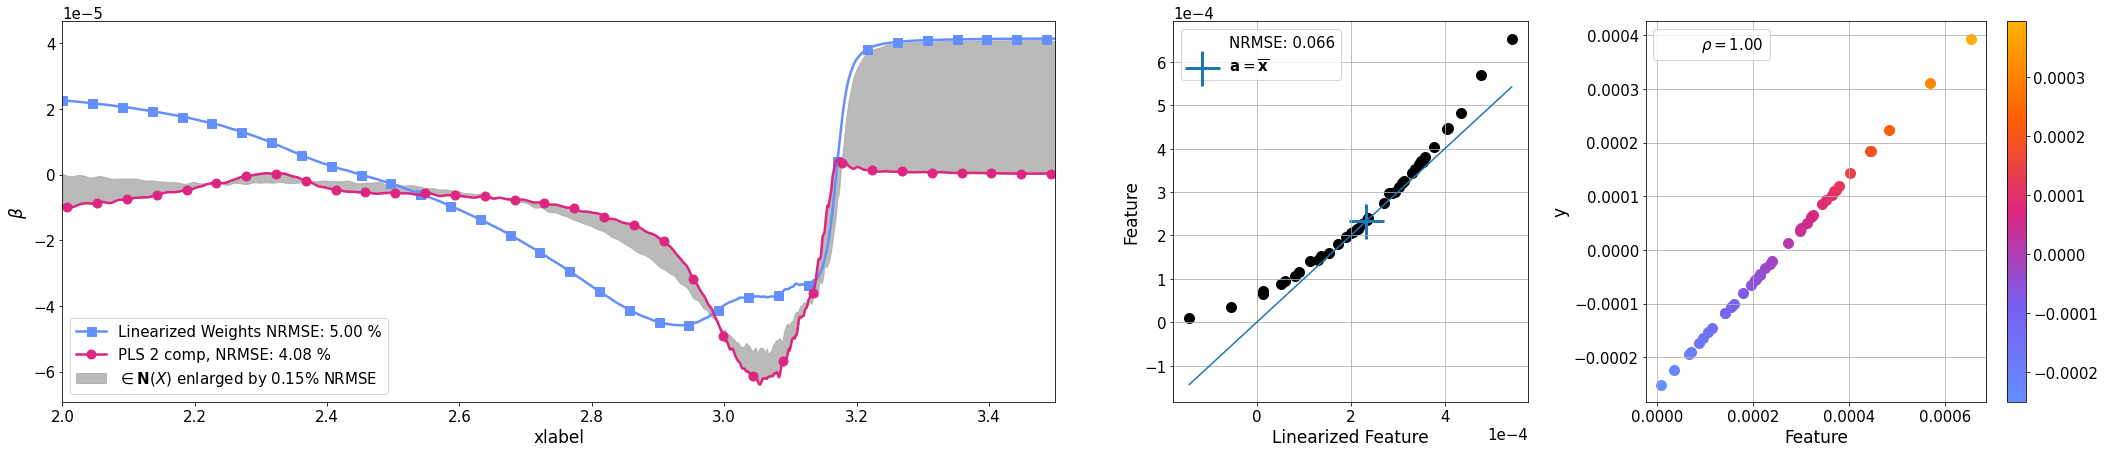

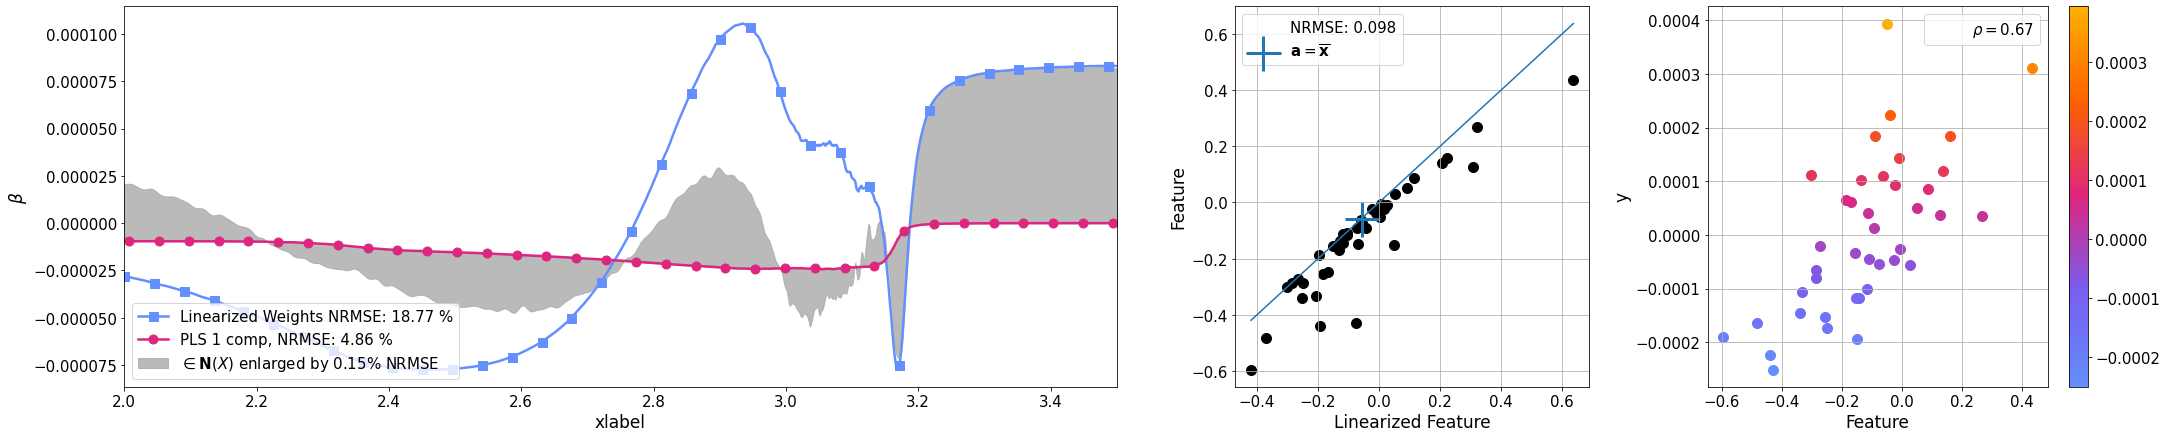

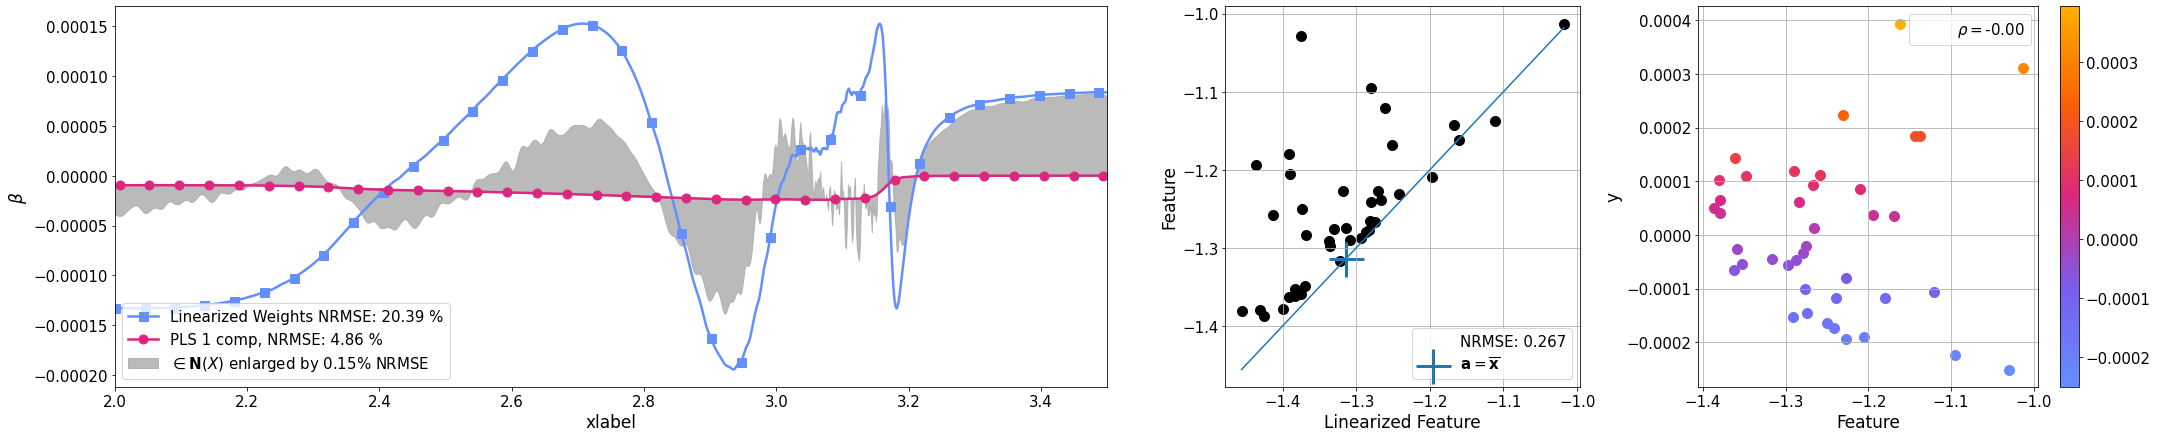

In [10]:
# Inititate the class with data (x, y) & features that you want to test
lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.12372740468617753
Beta NRMSE: 0.12108947512686322
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma value corresponding to nrmse=0.1456 % is 12.023
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.12372740468617753
Beta NRMSE: 0.12852957212892152
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma value corresponding to nrmse=0.1524 % is 22.909
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.12372740468617753
Beta NRMSE: 0.14514827166003763
Max NRMSE: 0.15
Gamma: 100000.0
Gamma: 0.01
Gamma: 0.25118864315095796
Gamma: 6.30957344480193
Gamma: 158.48931924611108
Gamma: 6.30957344480193
Gamma: 12.022644346174118
Gamma: 22.908676527677713
Gamma: 43.65158322401656
Gamma: 83.176377110267
Gamma: 158.4893

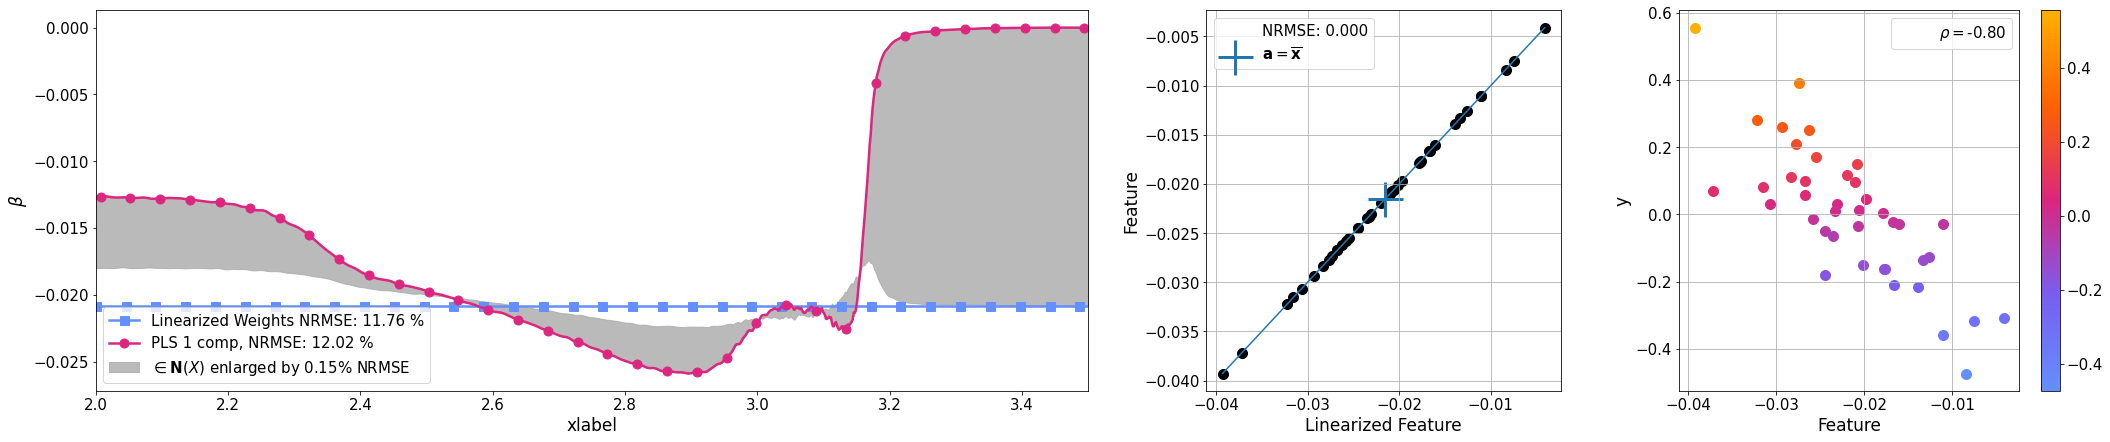

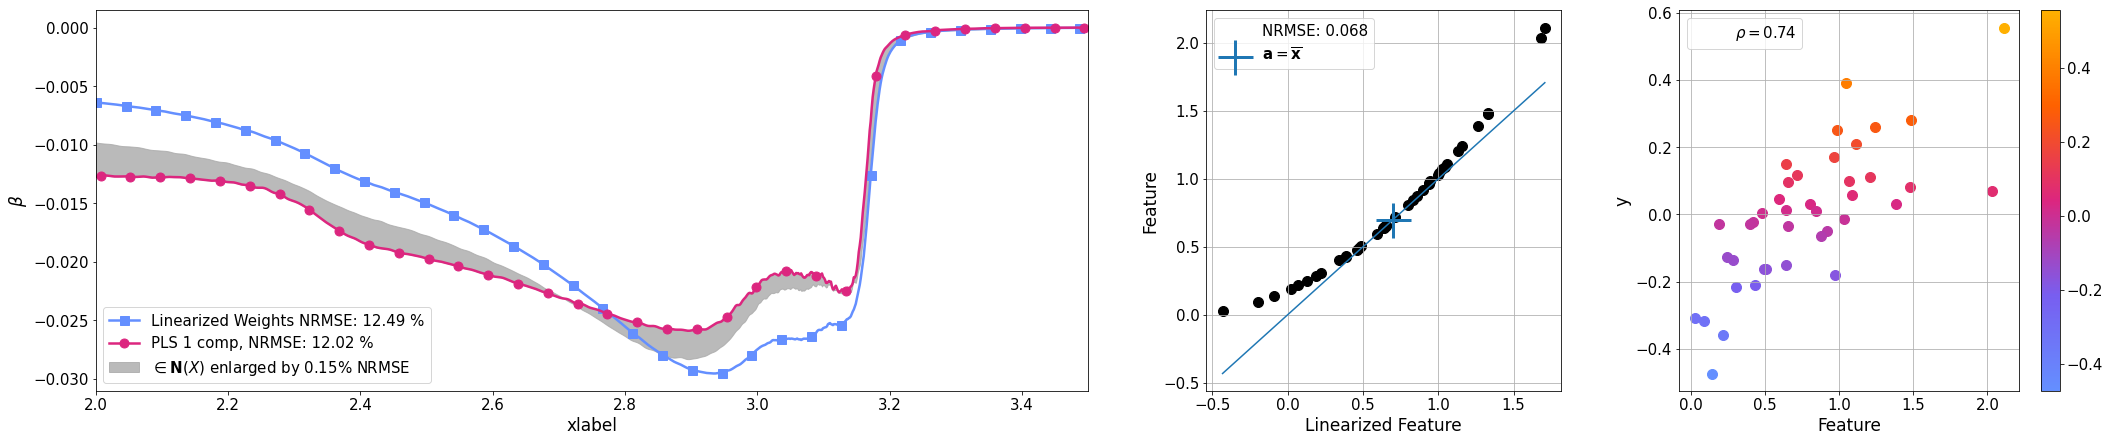

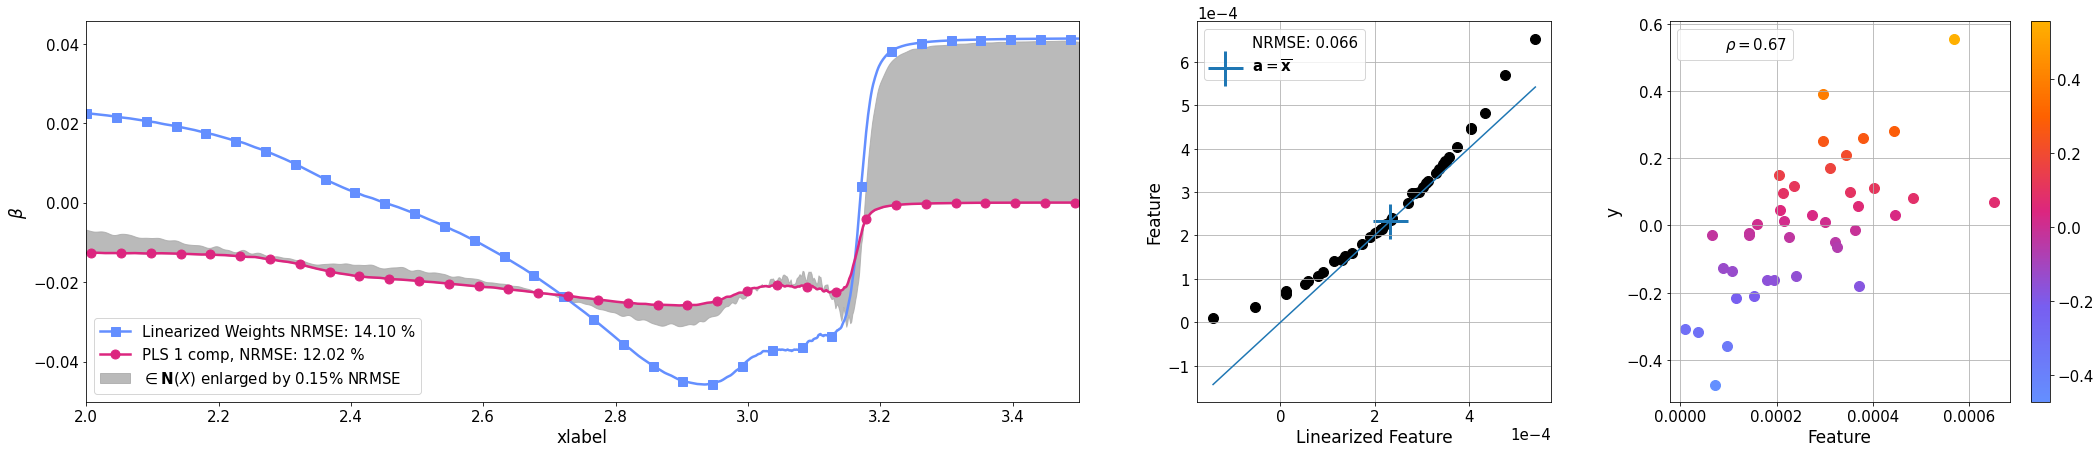

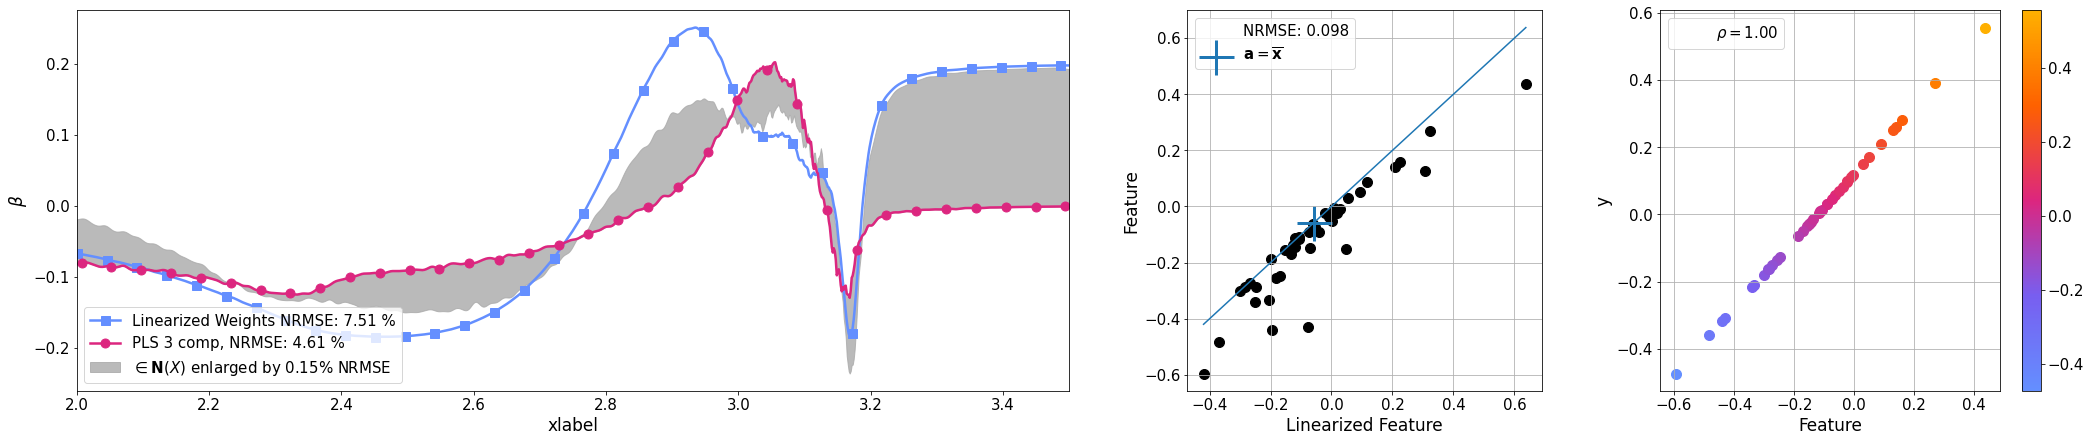

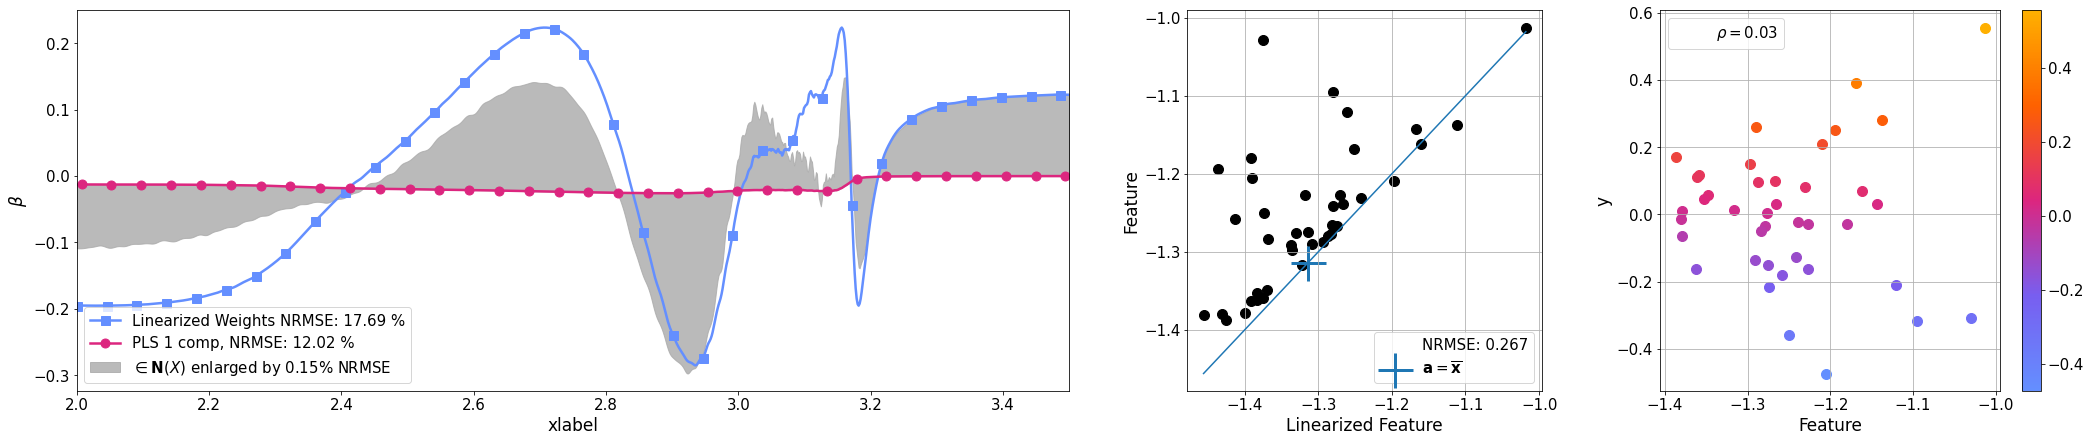

In [11]:
# Inititate the class with data (x, y) & features that you want to test
lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

# Run the tests
lfp_skew_gt = lfp_skew_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
plt.show()

['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.0918153021280372
Beta NRMSE: 0.09330943422196074
Max NRMSE: 0.15
Gamma value corresponding to nrmse=0.1480 % is 64.269
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.0918153021280372
Beta NRMSE: 0.09308049548711375
Max NRMSE: 0.15
Gamma value corresponding to nrmse=0.1477 % is 56.494
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.0918153021280372
Beta NRMSE: 0.09210319957840361
Max NRMSE: 0.15
['PLS 1 comp', 'lfun']
Alpha NRMSE: 0.0918153021280372
Beta NRMSE: 0.08893431905106557
Max NRMSE: 0.15
Gamma value corresponding to nrmse=0.1536 % is 233.346
['PLS 2 comp', 'lfun']
Alpha NRMSE: 0.05517885267399172
Beta NRMSE: 0.07230228727755932
Max NRMSE: 0.15
Gamma value corresponding to nrmse=0.1452 % is 139.316


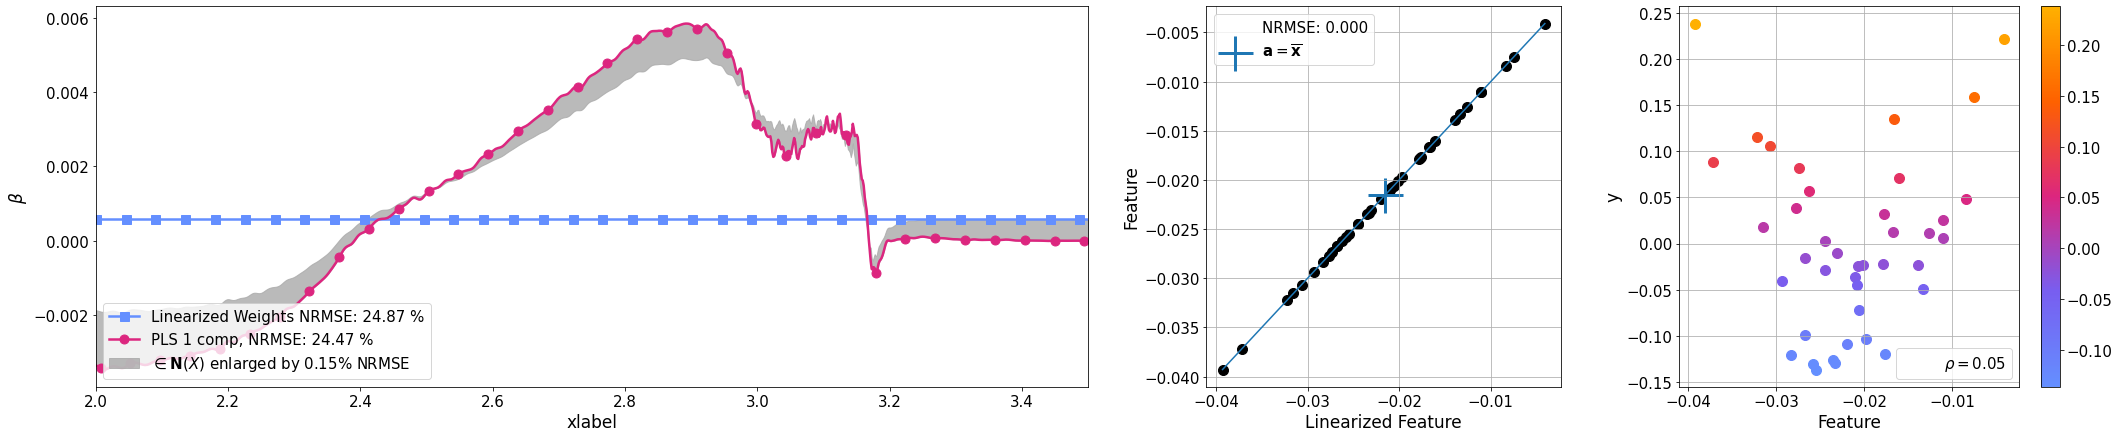

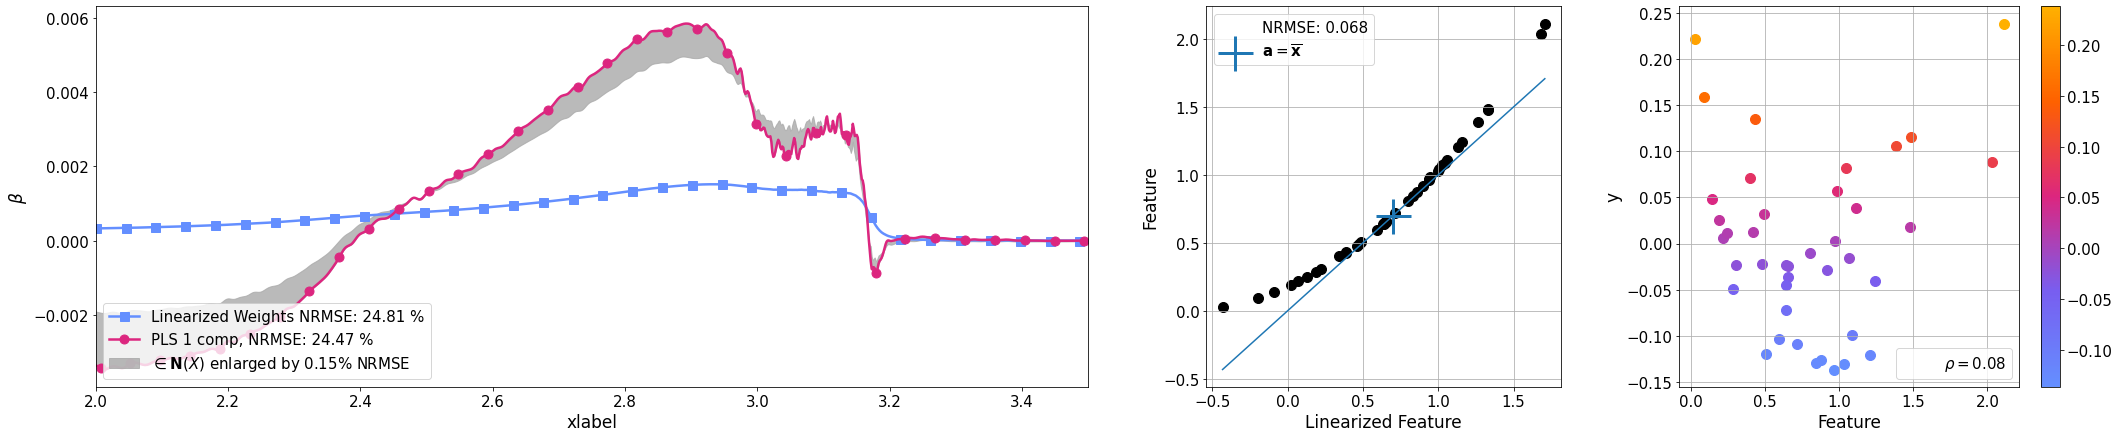

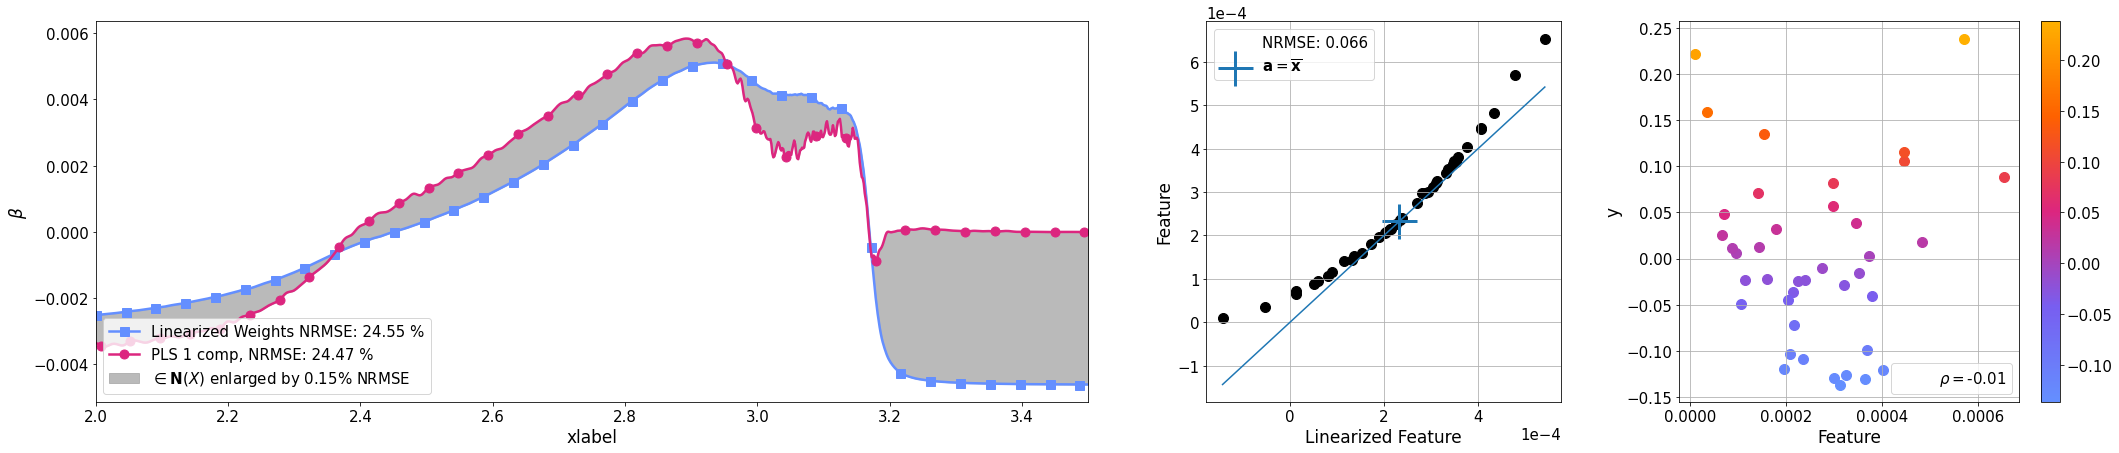

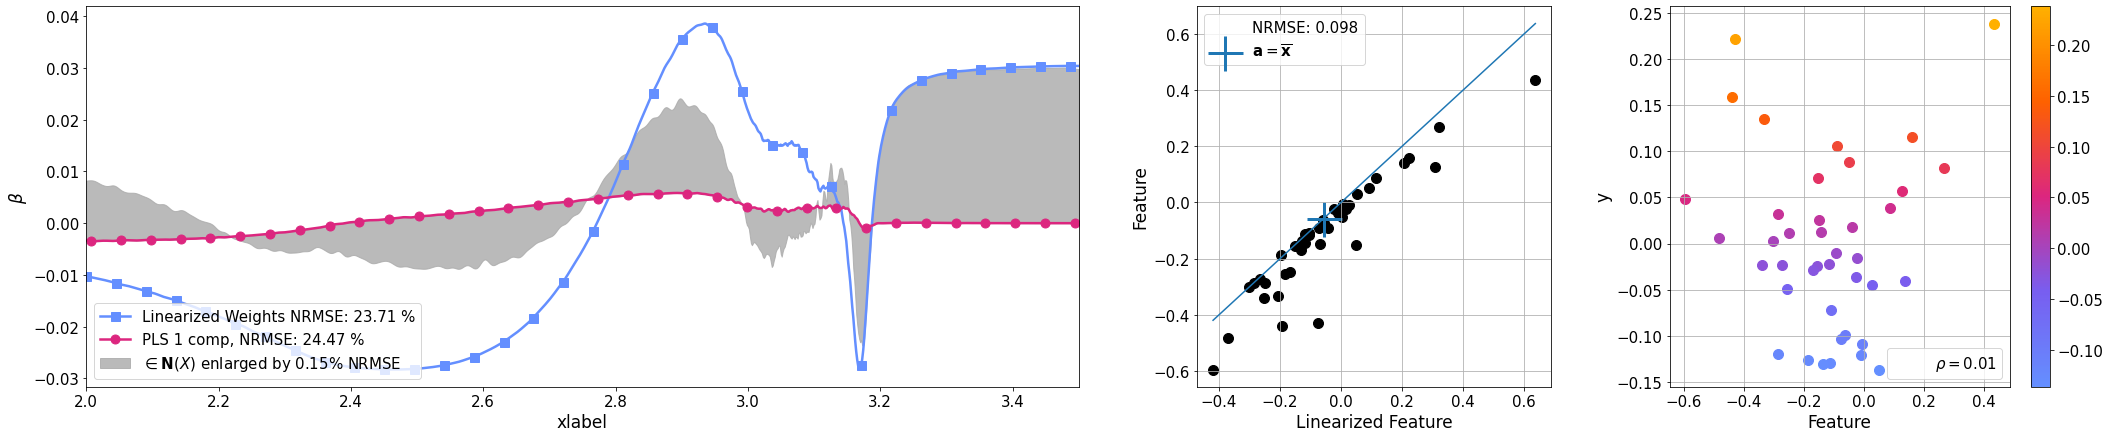

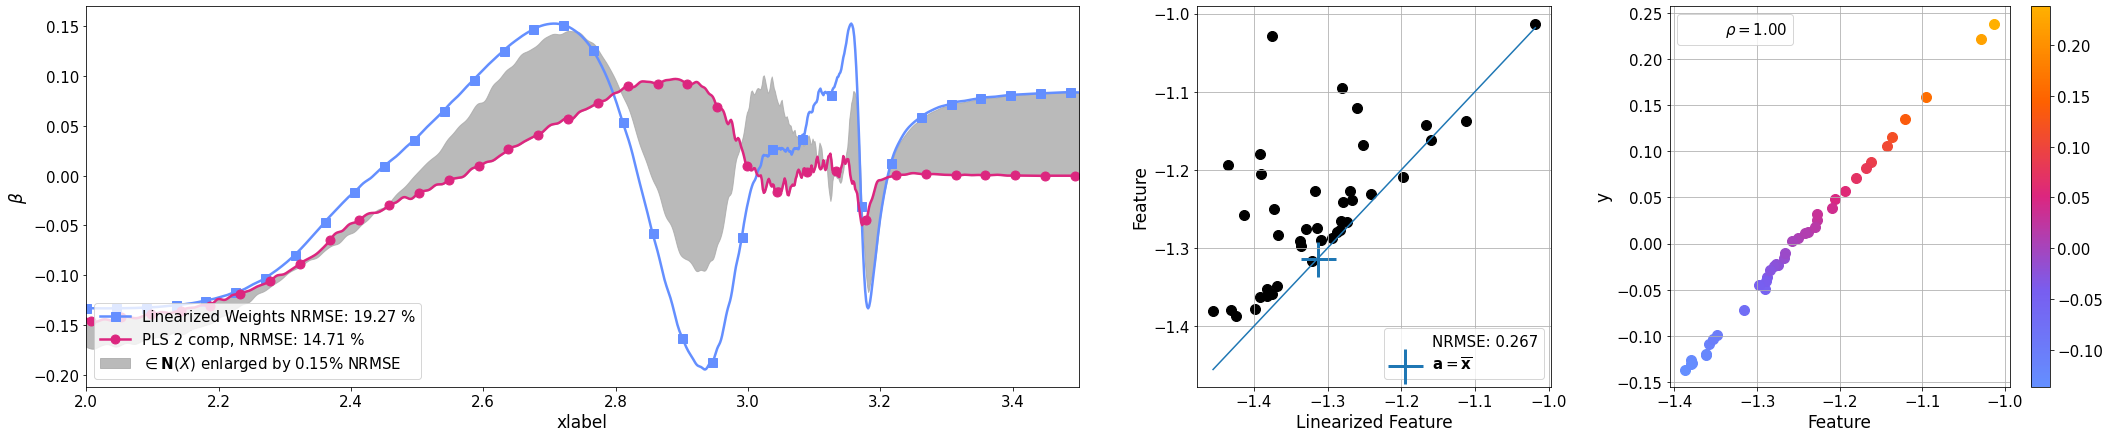

In [12]:
# Inititate the class with data (x, y) & features that you want to test
lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)

# Run the tests
lfp_kurt_gt = lfp_kurt_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
plt.show()

In [13]:
# Now redo the fun with RR model (:

In [14]:
# Then still the question remains, how to select the feature. 
# If the true feature is linear, easy. 
# If the true feature is nonlinear, then we're strongly limited
# By what we can show with thelinearized case.
# The linearized coefficients will make a mistake. 
# The nonlinear coefficients will make a mistake too. 
# Maybe we need to compare prediction between linearized 
# coefficients and regression coefficients? 

# Otherwise the meaning of thre prediction accouracy will be hard to compare. 

# Write functions that creates reuslts table: 

#Feature #NRMSE_Linearized #Closest_PLS_Model #NRMSE_PLS #Closest_RR_Model #NRMSE_RR #Pearson_Corr_Coefficient

# Assuming the featue IS the ground truth, which model predicts closes to it? 
# --> Select the feature! Which feature predicts closest to the linearized feature. Take th

# 1. Select with Pearson correlation coefficeints
# 2. Get insights into the feature with the linearization approach.
# 3. 
